In [ ]:
#import
!pip install brian2
from brian2 import *
from time import time
import numpy as np
import pandas as pd
#prefs.codegen.target = 'numpy'  # use the Python fallback
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os,pickle
from google.colab import drive
drive.mount('/content/drive')
%cd '/content/drive/My Drive/SNN-MNIST/'
import spikeTrain

     |████████████████████████████████| 1.5 MB 3.7 MB/s 
Mounted at /content/drive
/content/drive/My Drive/SNN-MNIST


In [ ]:
################################################################################
# Load data
################################################################################

# working directory path 
current_dir = os.getcwd()
###load all objects converted to poisson spike trains : a single sequence for each object 
file_to_read = open('/content/drive/My Drive/SNN-MNIST/initialization/poissonSpikeInput.pkl', "rb")
dict_poissonSpikeInput = pickle.load(file_to_read)
print(".....loading poisson spike trains input---here we will be checking only for 100/3000 ")
len(dict_poissonSpikeInput)
###load trainset
TrainSetSh=np.load('/content/drive/My Drive/SNN-MNIST/initialization/TrainSetSh.npy')
TrainSetTargetSh=np.load('/content/drive/My Drive/SNN-MNIST/initialization/TrainSetTargetSh.npy')
TrainSetSh=TrainSetSh[0:100,:,:]
TrainSetTargetSh=TrainSetTargetSh[0:100]

.....loading poisson spike trains input---here we will be checking only for 100/3000 


In [ ]:
################################################################################
# General parameters
################################################################################
n_input=1  #number of input : a single spike train
epoch=1
numberclass=100
segment_offset=0*ms
numberImg=100
segmentTime=350*ms
intervalImg=150
classlabel=[0,1,8]
################################################################################
# Model parameters
################################################################################
N_e=100
N_i=100
E_i_e=-100*mV
E_i_i=-85*mV
E_e=0*mV
E_l_e=-65*mV
E_l_i=-60*mV
v_reset_e = -60. *mV
v_reset_i = -45. *mV
v_thr_e = -55. *mV
v_thr_i = -40. *mV
refrac_e = 5. * ms
refrac_i = 2. * ms
################################################################################
# STDP parameters
################################################################################
taupre = 20*ms
taupost = taupre
gmax =100      #100 #.01
dApre =0.01      #.01
dApost = -dApre * taupre / taupost * 1.05
dApost *= gmax 
dApre *= gmax 

In [ ]:
dApre=0.4
dApost=-0.7

In [ ]:
start_scope()
################################################################################
# Preparing input
################################################################################
SGG = SpikeGeneratorGroup(n_input, np.zeros(100), np.zeros(100)*ms)

################################################################################
# Model definition
################################################################################

### Neurons
# excitatory group
neuron_eqs_e  = '''
dv/dt = (g_e*(E_e-v) + g_i*(E_i_e-v) + (E_l_e-v)) / (100*ms) : volt (unless refractory)
dg_e/dt = -g_e / (6*ms) : 1 # post-synaptic excitatory conductance  #5
dg_i/dt = -g_i / (8*ms) : 1 # post-synaptic inhibitory conductance
'''
#inhibitory group
neuron_eqs_i = '''
dv/dt = (g_e*(E_e-v) + g_i*(E_i_i-v) + (E_l_i-v)) / (10*ms) : volt (unless refractory)
dg_e/dt = -g_e / (1*ms) : 1 # post-synaptic excitatory conductance
dg_i/dt = -g_i / (2*ms) : 1 # post-synaptic inhibitory conductance
'''
EG       = NeuronGroup( N_e , model=neuron_eqs_e,
                            threshold='v>v_thr_e', reset='v=v_reset_e', refractory='refrac_e',method='euler',name='EG')
IG       = NeuronGroup( N_i , model=neuron_eqs_i,
                            threshold='v>v_thr_i', reset='v=v_reset_i', refractory='refrac_i',method='euler',name='IG')
#EG.v=E_l_e - 40*mV

EG.v=E_l_e    #20
IG.v=E_l_i    #20

###synapses
#-----------------------------------------------------------------------------
# Apre and Apost - presynaptic and postsynaptic traces, lr - learning rate
#stdp='''w : 1
#    lr_pree : 1 (shared)
#    lr_postt : 1 (shared)
#   dApre/dt = -Apre / taupre : 1 (event-driven)
 #   dApost/dt = -Apost / taupost : 1 (event-driven)'''
#stdp_pre='''g_e += w
 #   Apre += dApre
 #   w = clip(w + lr_pree*Apost, 0, gmax)'''
#stdp_post='''Apost += dApost
#    w = clip(w + lr_postt*Apre, 0, gmax)'''

#-----------------------------------------------------------------------------
tc_pre_ee = 20*ms
tc_post_1_ee = 20*ms
tc_post_2_ee = 40*ms
nu_ee_pre =  0.0001      # learning rate
nu_ee_post = 0.01       # learning rate
wmax_ee = 100.0


eqs_stdp_ee = '''
                w:1
                post2before                            : 1
                dpre/dt   =   -pre/(tc_pre_ee)         : 1 (event-driven)
                dpost1/dt  = -post1/(tc_post_1_ee)     : 1 (event-driven)
                dpost2/dt  = -post2/(tc_post_2_ee)     : 1 (event-driven)
            '''
eqs_stdp_pre_ee = 'g_e_post += w; pre = 1.; w = clip(w + nu_ee_pre * post1, 0, wmax_ee)'
eqs_stdp_post_ee = 'post2before = post2; w = clip(w + nu_ee_post * pre * post2before, 0, wmax_ee); post1 = 1.; post2 = 1.'


#create input synapse
PG_syn= Synapses(SGG, EG, eqs_stdp_ee, on_pre=eqs_stdp_pre_ee, on_post=eqs_stdp_post_ee, method='euler', name='PG_syn')
PG_syn.connect()

#PG_syn.w = 'rand()*0.3' # random weights initialisation
#np.save('/content/drive/My Drive/SNN-MNIST/initialization/PG_syn_w0.npy',np.array(PG_syn.w))
PG_syn.w=np.load('/content/drive/My Drive/SNN-MNIST/initialization/PG_syn_w0.npy')+0.2
#PG_syn.w=[15.1,15.3,15.5]
#PG_syn.w=[0.1,0.2,0.3]

#PG_syn.lr_pree =  0.0001  # learning rate
#PG_syn.lr_postt = 0.01    #learning rate

#PG_syn.delay='rand()*10*ms'
#np.save('/content/drive/My Drive/SNN-MNIST/initialization/PG_syn_delay.npy',np.array(PG_syn.delay))
PG_syn.delay=np.load('/content/drive/My Drive/SNN-MNIST/initialization/PG_syn_delay.npy')*second
#PG_syn.delay=[2,4,6]*ms
print("weight",PG_syn.w[0:10])
print("delay", PG_syn.delay[0:10])

#create recurrent connection
EI_syn= Synapses(EG, IG, 'w : 1', on_pre='g_e_post += w', name='EI_syn')
EI_syn.connect(j='i')
EI_syn.w = 10.4   #8
#create lateral inhibition
IE_syn= Synapses(IG, EG, 'w : 1', on_pre='g_i_post += w', name='IE_syn')
IE_syn.connect('i!=j')
IE_syn.w = 15 #0.5

weight [0.46456468 0.43735379 0.46726514 0.43858942 0.48817874 0.47258068
 0.28852087 0.23447625 0.21316829 0.41404267]
delay [7.32476792 9.84627581 1.50877441 5.42850994 1.27290655 9.71710958
 1.92970078 9.97429815 1.64700037 8.30503047] ms


In [ ]:
#monitor state variables
exc_mon = SpikeMonitor(EG)
inh_mon = SpikeMonitor(IG)
E_stat=StateMonitor(EG,['v','g_e','g_i'],record=True)
I_stat=StateMonitor(IG,['v','g_e'],record=True)
#PE_stat= StateMonitor(PG_syn, ['w', 'Apre', 'Apost'], record=True)
PE_stat= StateMonitor(PG_syn, ['w'], record=True)

In [ ]:
def addSegmentToPoissonSpikes(spikes_t,addSegment):
    for index13 in np.arange(len(spikes_t)):
        spikes_t[index13] += addSegment
    return spikes_t  
begin_time = datetime.datetime.now()
print("Training is starting at  : ",begin_time)
spikeCount=np.zeros([(epoch*numberImg)+1,N_e])
oldspikeCount=np.zeros(N_e)
duration=numberImg*(intervalImg*ms+segmentTime)
iteration=0
segment_offset=0*ms

for ep in np.arange(epoch):
    print("epoch "+str(ep)+" is runing:")
    print("segment_offset",segment_offset)
    for idx in np.arange(numberImg):
        
        SGG.active=False
        run(intervalImg*ms, report='text')
        oldspikeCount=exc_mon.count[:]
        #print("spike count after interval time", oldspikeCount)
        
        SGG.active=True
        segment_offset=segment_offset+intervalImg*ms
        print("segment_offset ",segment_offset)
        spikes_t=addSegmentToPoissonSpikes(dict_poissonSpikeInput[idx]*ms,segment_offset)
        #print("spikes_t_after "+str(stimulusIdx),spikes_t)
               
        SGG.set_spikes(np.zeros(len(dict_poissonSpikeInput[idx])),spikes_t)
        #print("SGG._spike_time",SGG._spike_time)
        #print(SGG.get_states)
        run(segmentTime, report='text')
        spikeCount[iteration,:]=exc_mon.count[:]-oldspikeCount
        
        print("spikeCount["+str(iteration)+"]\n",spikeCount[iteration,:])
        oldspikeCount=exc_mon.count[:]
         
        segment_offset=segment_offset+segmentTime
        #np.save(current_dir +'\\result\\weight\\w_e_t'+str(iteration),np.array(out_exc_syn.w_e_t[:]))
        #np.save(current_dir +'\\result\\weight\\w_i_t'+str(iteration),np.array(out_inh_syn.w_i_t[:]))
        
        iteration+=1
    
        
             
        
end_time=datetime.datetime.now()
print("Training finished at ",end_time - begin_time)        

Training is starting at  :  2022-04-01 19:20:21.998191
epoch 0 is runing:
segment_offset 0. s
Starting simulation at t=0. s for a duration of 150. ms
150. ms (100%) simulated in < 1s
segment_offset  150. ms
Starting simulation at t=150. ms for a duration of 0.35 s
0.35 s (100%) simulated in 1s
spikeCount[0]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 7. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]
Starting simulation at t=0.5 s for a duration of 150. ms
150. ms (100%) simulated in < 1s
segment_offset  0.65 s
Starting simulation at t=0.65 s for a duration of 0.35 s
0.35 s (100%) simulated in 1s
spikeCount[1]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 9. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0

In [ ]:
numSp,maxSpInput,sameMaxSpInput,idxMaxSpInput,zeroNumSp,numIdentical=spikeTrain.spCountNeuronPerInput(segmentTime,intervalImg,exc_mon,numberImg,epoch,numberclass)
print(zeroNumSp)
print(numIdentical)
print(sameMaxSpInput)

WARNING    /content/drive/My Drive/SNN-MNIST/spikeTrain.py:55: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ti_sptrains_np=np.array(list(ti_sptrains.items()))
 [py.warnings]


0
0
[[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
  1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
  1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
  1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
  1. 1. 1. 1.]]


In [ ]:
numberclass=N_e
numberclass
classlabel

[0, 1, 8]

In [ ]:
spikeTrain.get_IndexNeuronPerInput(TrainSetSh,TrainSetTargetSh,idxMaxSpInput,epoch,classlabel)

{0: array([27]), 1: array([27]), 8: array([27])}

In [ ]:
PG_syn.w 

<PG_syn.w: array([11.2458612 , 15.8951018 , 18.86678399,  1.51962848,  3.20389552,
        0.2763791 ,  2.00015727,  3.7089977 ,  1.84213074,  1.37155691,
        2.96613967, 17.74744637,  7.23554919,  4.28999063, 22.05976426,
        3.48896217,  0.33278728,  3.05924713, 22.35657951,  3.5610601 ])>

In [ ]:
print(inh_mon.count)
print(exc_mon.count)


<spikemonitor_3.count: array([1336, 1933, 2249,   28,   32,    0,   29,   59,   29,   27,   31,
       2131,  778,  254, 2600,   54,    0,   31, 2685,   54], dtype=int32)>
<spikemonitor_2.count: array([1336, 1933, 2249,   28,   32,    0,   29,   59,   29,   27,   31,
       2131,  778,  254, 2600,   54,    0,   31, 2685,   54], dtype=int32)>


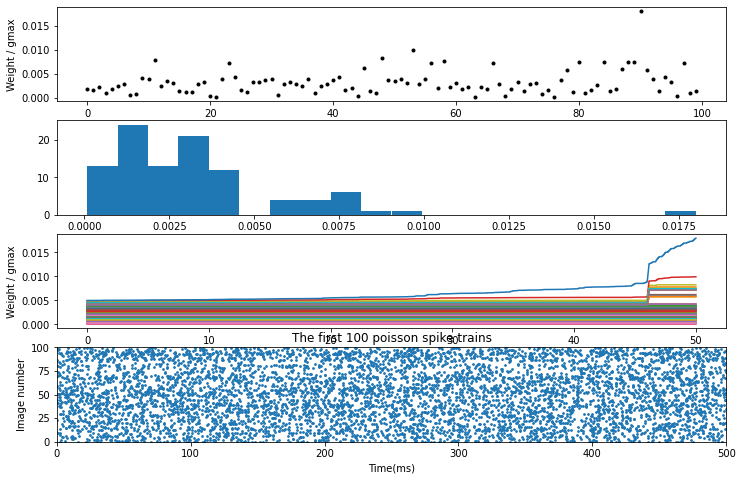

<Figure size 640x480 with 0 Axes>

In [ ]:
figure(figsize=(12,8))
subplot(411)
plot(PG_syn.w / gmax, '.k')
ylabel('Weight / gmax')
xlabel('Synapse index')
subplot(412)
hist(PG_syn.w / gmax, 20)
xlabel('Weight / gmax')
subplot(413)
plot(PE_stat.t/second, PE_stat.w.T/gmax)
xlabel('Time (s)')
ylabel('Weight / gmax')
subplot(414)
mpl.rcParams.update(mpl.rcParamsDefault)
#plt.subplot(311)
for ii in np.arange(len(dict_poissonSpikeInput)-2900):
    plt.scatter( dict_poissonSpikeInput[ii],ii*np.ones(len(dict_poissonSpikeInput[ii])),s=3,c='#1f77b4')
    # Set axes limit
    plt.xlim(0, 500)
    plt.ylim(0,100)
    plt.xlabel("Time(ms)")
    plt.ylabel("Image number")
    plt.title("The first 100 poisson spike trains")

plt.show()
tight_layout()
show()